In [699]:
using Revise
using HypergraphDetectability
using DataFrames
using Clustering
using Statistics
using RCall
using Arpack
using Plots
using StatsBase
using SparseArrays
using Kronecker: ⊗
using LinearAlgebra
using SparseArrays

In [641]:
n  = 100
c₂ = 10
c₃ = 10
z  = 1 .+ (1:n .> n/2);

p₂ = 0.25
p₃ = 0.4

H = detectabilityData(n, c₂, c₃, p₂, p₃);

In [642]:
Bs = reducedNonBacktrackingMatrices(H);

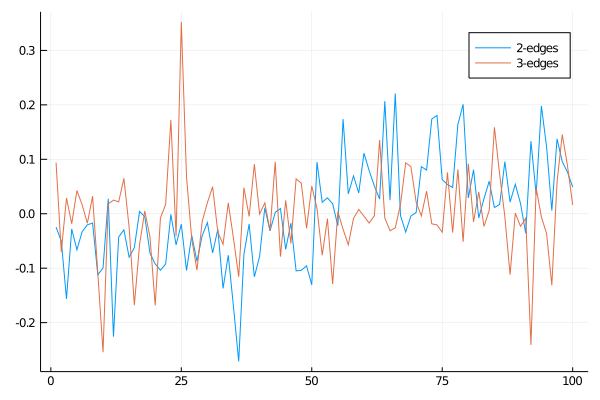

In [643]:
E = Arpack.eigs(Bs[2]; nev = 2, ritzvec = true);
u = E[2][:,2];
λ₂ = E[1][2]
plot(real.(u)[1:n], label = "2-edges")

E = Arpack.eigs(Bs[3]; nev = 2, ritzvec = true);
λ₃ = E[1][2]
v = E[2][:,2];
plot!(real.(v)[1:n], label = "3-edges")

In [644]:
ρ = cor(u, v)

0.03165512197892012 + 0.03552979710185491im

In [645]:
λ₂, λ₃

(-4.0825285915987175 + 0.0im, 2.461304518471513 + 3.8793442026253238im)

In [646]:
BP_mat, ix = linearizedBPMatrix(H, z; reduced = true);
E = Arpack.eigs(BP_mat; nev = 3, ritzvec = true, tol = 1e-10);

In [647]:
abs(E[1][3])

3.255182673639409

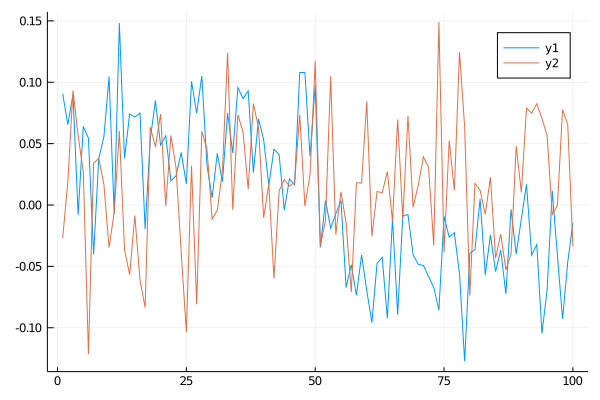

In [648]:
u = E[2][:,1][(n+1):2n]
plot(real.(u)[1:n])

u = E[2][:,2][(n+1):2n]
plot!(real.(u)[1:n])

In [649]:
clusters = 1 .+ (real.(u) .> 0)
mi = mutualinfo(clusters, z)

0.000308672876918921

In [650]:
E = Arpack.eigs(BP_mat; nev = 100, ritzvec = true, tol = 1e-16);

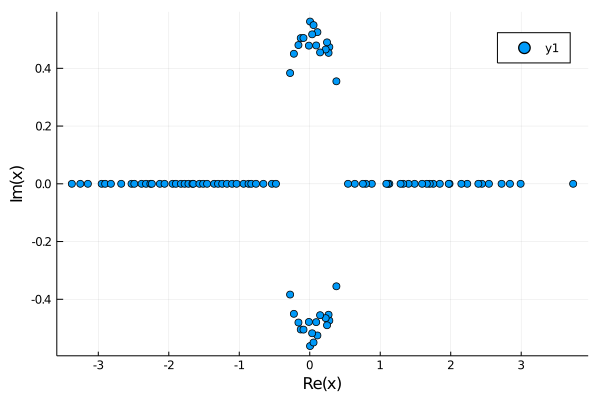

In [652]:
BP_mat, ix = linearizedBPMatrix(H, z; reduced = true);
E = Arpack.eigs(BP_mat; nev = 100, ritzvec = true, tol = 1e-16);
plot(E[1], seriestype = :scatter)

# BP Jacobian Reduction: Scratchwork

First, let's compute the true spectrum of the BP Jacobian. This is the spectrum which we would like to reproduce in a reduced version of the matrix. 

┌ Warning: Adjusting nev from 500 to 398
└ @ Arpack /home/phil/.julia/packages/Arpack/o35I5/src/Arpack.jl:82


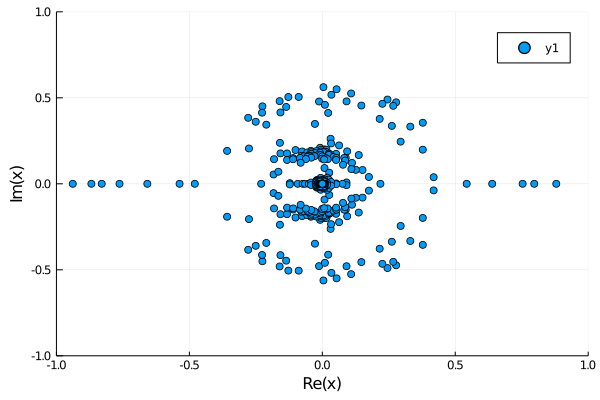

In [667]:
BP_mat, ix = linearizedBPMatrix(H, z; reduced = true);

E = Arpack.eigs(BP_mat; nev = 500)
plot(E[1], seriestype = :scatter)
plot!(xlim = (-1, 1), ylim = (-1, 1))

So, let's see if we can reproduce this. Fundamentally, all we need to do is construct a matrix of the correct dimensions and check its spectrum. 

In [776]:
c, G = degreeTensor(H, z);
ẑ = z
q = 1/n * StatsBase.counts(ẑ)
C_ = zero(G)
for k ∈ 1:size(G)[1]
    C_[k,:,:] = (G[k,:,:] / ((k - 1) * c[k]) .- 1) .* q
end

In [777]:
# at the moment, this doesn't include a placeholder for size 1 edges, so that's a source of possible errors. 
n = length(H.D)
D = HypergraphDetectability.degreeMatrix(H);

In [795]:
# adjacency operator

a = hcat([HypergraphDetectability.adjacencyMatrix(H, k) for k ∈ 2:k̄]...)
A = vcat([a for k ∈ 2:k̄]...);

In [796]:
k̄ = maximum(keys(H.E))
ℓ = length(unique(z))

Cs = [C_[k,:,:] for k ∈ 2:k̄]

sumC = sum(Cs)
C = cat(Cs..., dims=(1,2))

# upper-right block? 
upperRight = sparse(sum(Cs) ⊗ D) - sparse(C ⊗ I(n));
size(upperRight) # correct dimensions
# upperRight

(400, 400)

In [797]:
K = diagm(2:k̄)
# lower lefthand corner? 
lowerLeft = sparse((C * (I(ℓ) ⊗ (I - K))) ⊗ I(n))

400×400 SparseMatrixCSC{Float64,Int64} with 800 stored entries:
  [1  ,   1]  =  0.271058
  [101,   1]  =  -0.2473
  [2  ,   2]  =  0.271058
  [102,   2]  =  -0.2473
  [3  ,   3]  =  0.271058
  [103,   3]  =  -0.2473
  [4  ,   4]  =  0.271058
  [104,   4]  =  -0.2473
  [5  ,   5]  =  0.271058
  [105,   5]  =  -0.2473
  [6  ,   6]  =  0.271058
  [106,   6]  =  -0.2473
  ⋮
  [394, 394]  =  -0.109109
  [295, 395]  =  0.191191
  [395, 395]  =  -0.109109
  [296, 396]  =  0.191191
  [396, 396]  =  -0.109109
  [297, 397]  =  0.191191
  [397, 397]  =  -0.109109
  [298, 398]  =  0.191191
  [398, 398]  =  -0.109109
  [299, 399]  =  0.191191
  [399, 399]  =  -0.109109
  [300, 400]  =  0.191191
  [400, 400]  =  -0.109109

In [801]:
# I(ℓ)⊗(K - 2I)⊗I(n)

lowerRight = sumC ⊗ A - (C*(I(ℓ)⊗(K - 2I)))⊗I(n)

400×400 Array{Float64,2}:
 -0.0  -0.0       -0.0       -0.0       …   0.0         0.0         0.151705
 -0.0  -0.0       -0.0       -0.0           0.0         0.0         0.0
 -0.0  -0.0       -0.0       -0.0           0.0         0.0         0.0
 -0.0  -0.0       -0.0       -0.0           0.151705    0.0         0.151705
 -0.0  -0.0       -0.0       -0.0           0.0         0.0         0.0
 -0.0  -0.0       -0.0       -0.0       …   0.0         0.151705    0.0
 -0.0  -0.0       -0.0       -0.0           0.0         0.0         0.0
 -0.0  -0.0       -0.134422  -0.0           0.0         0.0         0.0
 -0.0  -0.0       -0.0       -0.0           0.151705    0.0         0.0
 -0.0  -0.0       -0.0       -0.0           0.0         0.0         0.0
 -0.0  -0.0       -0.0       -0.0       …   0.0         0.0         0.0
 -0.0  -0.0       -0.0       -0.134422      0.0         0.0         0.0
 -0.0  -0.0       -0.0       -0.0           0.0         0.0         0.0
  ⋮                         

In [806]:
B_ = hcat(zero(upperRight), upperRight);
B_ = vcat(B_, hcat(lowerLeft, lowerRight));

In [807]:
E_ = Arpack.eigs(B_; nev = 500)

(Complex{Float64}[-9.363052296146776 + 0.0im, -3.0907181055786097 + 0.0im, 3.045397986122905 + 0.0im, -2.918449694613431 + 0.0im, 2.9041115830431323 + 0.0im, -2.7407452429862795 + 0.0im, 2.686705682741329 + 0.0im, 2.6736253254566313 + 0.0im, 2.634722033245157 + 0.0im, -2.577036877920942 + 0.0im  …  0.09855004158667546 - 0.1319442046543388im, 0.05798774438681973 + 0.15028084361870944im, 0.05798774438681973 - 0.15028084361870944im, 0.04400453684934097 + 0.14819141056391086im, 0.04400453684934097 - 0.14819141056391086im, -0.14378824630982007 + 0.05654331034548437im, -0.14378824630982007 - 0.05654331034548437im, -0.008395573287348397 + 0.15398408070630618im, -0.008395573287348397 - 0.15398408070630618im, 0.12033500818882509 + 0.09349062168908262im], Complex{Float64}[0.014564413071978645 + 0.0im 0.024086606980618035 + 0.0im … -0.08044587507805934 + 0.01402439403013897im 0.06703392262456012 + 0.039355768719512324im; 0.01115954262165985 + 0.0im -0.0021349953962591494 + 0.0im … -0.059717261624

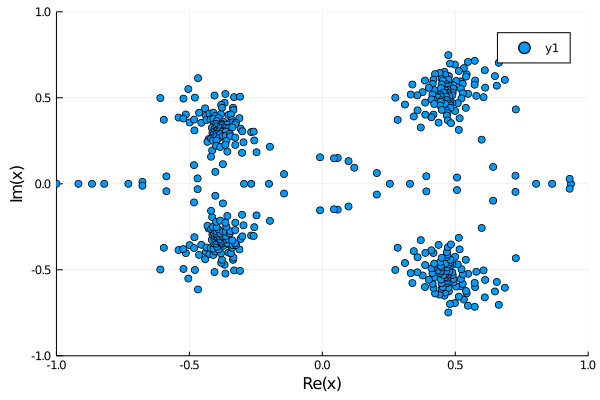

In [809]:
# well, certain things are likely correct here but the overall result certainly isn't!! 
# maybe a good path is to start by refactoring the notation and constructs for the basic 
# reduction, and then seeing which of those can be gracefully re-used in the more complex computation. 

plot(E_[1], seriestype = :scatter)
plot!(xlim = (-1, 1), ylim = (-1, 1))